In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
yolo = YOLO("YOLODataset_seg/yolo11s-seg.pt")
    
print("NAMES:", yolo.names)

img = "valid/0e7f70b3-9d9f-4a2d-a900-d8dba3d1305f.jpg"

predict = yolo.predict(img, imgsz = 640, conf = 0.80)

# Cargar y mostrar la imagen
img = plt.imread(img)
fig, ax = plt.subplots()
ax.imshow(img)

# Obtener las coordenadas de la bbox
boxes = predict[0].boxes  # Acceder a las boxes del primer resultado
x1, y1, x2, y2 = boxes.xyxy[0].cpu().numpy()  # Obtener coordenadas de la primera bbox
class_id = boxes.cls[0].item()  # Obtiene el índice de la clase
label = predict[0].names[int(class_id)]  # Convierte el índice al nombre de la clase
print(f"Objeto detectado: {label}")

# Crear el rectángulo
width = x2 - x1
height = y2 - y1
bbox = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')

# Agregar el rectángulo a la imagen
ax.add_patch(bbox)

plt.show()

In [ ]:
import os

def process_directory(input_dir, output_dir, model_path):
    os.makedirs(output_dir, exist_ok=True)
    yolo = YOLO(model_path)
    
    valid_extensions = ('.jpg', '.jpeg', '.png')
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(valid_extensions)]
    
    for img_file in image_files:
        input_path = os.path.join(input_dir, img_file)
        output_path = os.path.join(output_dir, f"bbox_{img_file}")
            
        try:
            predict = yolo.predict(input_path, imgsz=640, conf=0.80)
            fig, ax = plt.subplots()
            img = plt.imread(input_path)    
            ax.imshow(img)
            
            if len(predict[0].boxes) > 0:
                boxes = predict[0].boxes
                # Obtener las clases y confianzas
                cls = boxes.cls.cpu().numpy()  # Índices de las clases
                conf = boxes.conf.cpu().numpy()  # Valores de confianza
                
                for i, box in enumerate(boxes.xyxy.cpu().numpy()):
                    x1, y1, x2, y2 = box
                    width = x2 - x1
                    height = y2 - y1
                    
                    # Obtener el nombre de la clase
                    class_id = int(cls[i])
                    class_name = predict[0].names[class_id]  # Obtiene el nombre de la clase
                    confidence = conf[i]
                    
                    # Crear el rectángulo
                    bbox = patches.Rectangle(
                        (x1, y1), width, height,
                        linewidth=2, edgecolor='r', facecolor='none'
                    )
                    ax.add_patch(bbox)
                    
                    # Añadir texto con clase y confianza
                    plt.text(x1, y1-10, f'{class_name} {confidence:.2f}', 
                            color='red', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
                    
                    # También imprimir en consola
                    print(f"Detección en {img_file}: Clase={class_name}, Confianza={confidence:.2f}")
            
            plt.axis('off')
            plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
            plt.close()
            
            print(f"Procesado: {img_file}")
            
        except Exception as e:
            print(f"Error procesando {img_file}: {str(e)}")
            continue

# Uso del script
input_directory = "test"
output_directory = input_directory + "_with_bbox"
model_path = "YOLODataset_seg/runs/segment/train2/weights/best.pt"

process_directory(input_directory, output_directory, model_path)

In [ ]:
import os
import json

def update_json_labels(directory_path, new_label):
    """
    Recorre un directorio buscando archivos .json y actualiza el valor de 'label' en todos los shapes.

    Args:
        directory_path (str): Ruta al directorio que contiene los archivos JSON
        new_label (str): Nuevo valor para el campo 'label'
    """
    # Recorrer todos los archivos en el directorio
    for filename in os.listdir(directory_path):
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)

            try:
                # Leer el archivo JSON
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                # Verificar si existe la clave 'shapes'
                if 'shapes' in data and isinstance(data['shapes'], list):
                    # Actualizar el label en cada shape
                    modified = False
                    for shape in data['shapes']:
                        if 'label' in shape:
                            shape['label'] = new_label
                            modified = True

                    # Si se hizo algún cambio, guardar el archivo
                    if modified:
                        with open(file_path, 'w', encoding='utf-8') as f:
                            json.dump(data, f, indent=2, ensure_ascii=False)
                        print(f"Actualizado: {filename}")
                    else:
                        print(f"No se encontró 'label' en shapes de: {filename}")
                else:
                    print(f"No se encontró la estructura esperada en: {filename}")

            except json.JSONDecodeError:
                print(f"Error al leer el JSON en: {filename}")
            except Exception as e:
                print(f"Error procesando {filename}: {str(e)}")

# Ejemplo de uso
if __name__ == "__main__":
    directory = "validrecorte/Dorso"  # Cambia esto por tu ruta
    new_label_value = "DorsoValido"     # Cambia esto por el nuevo valor que quieres
    update_json_labels(directory, new_label_value)

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n-cls.pt') 

# Entrenar el modelo
results = model.train(
    data='data',
    epochs=60,
    imgsz=224,
    batch=8
)

Evaluando 10 imágenes...


100%|██████████| 10/10 [00:00<00:00, 18.75it/s]



Resultados:
Total imágenes evaluadas: 10
Clasificadas como 'valid': 4
Clasificadas como 'invalid': 6
Porcentaje 'valid': 40.00%


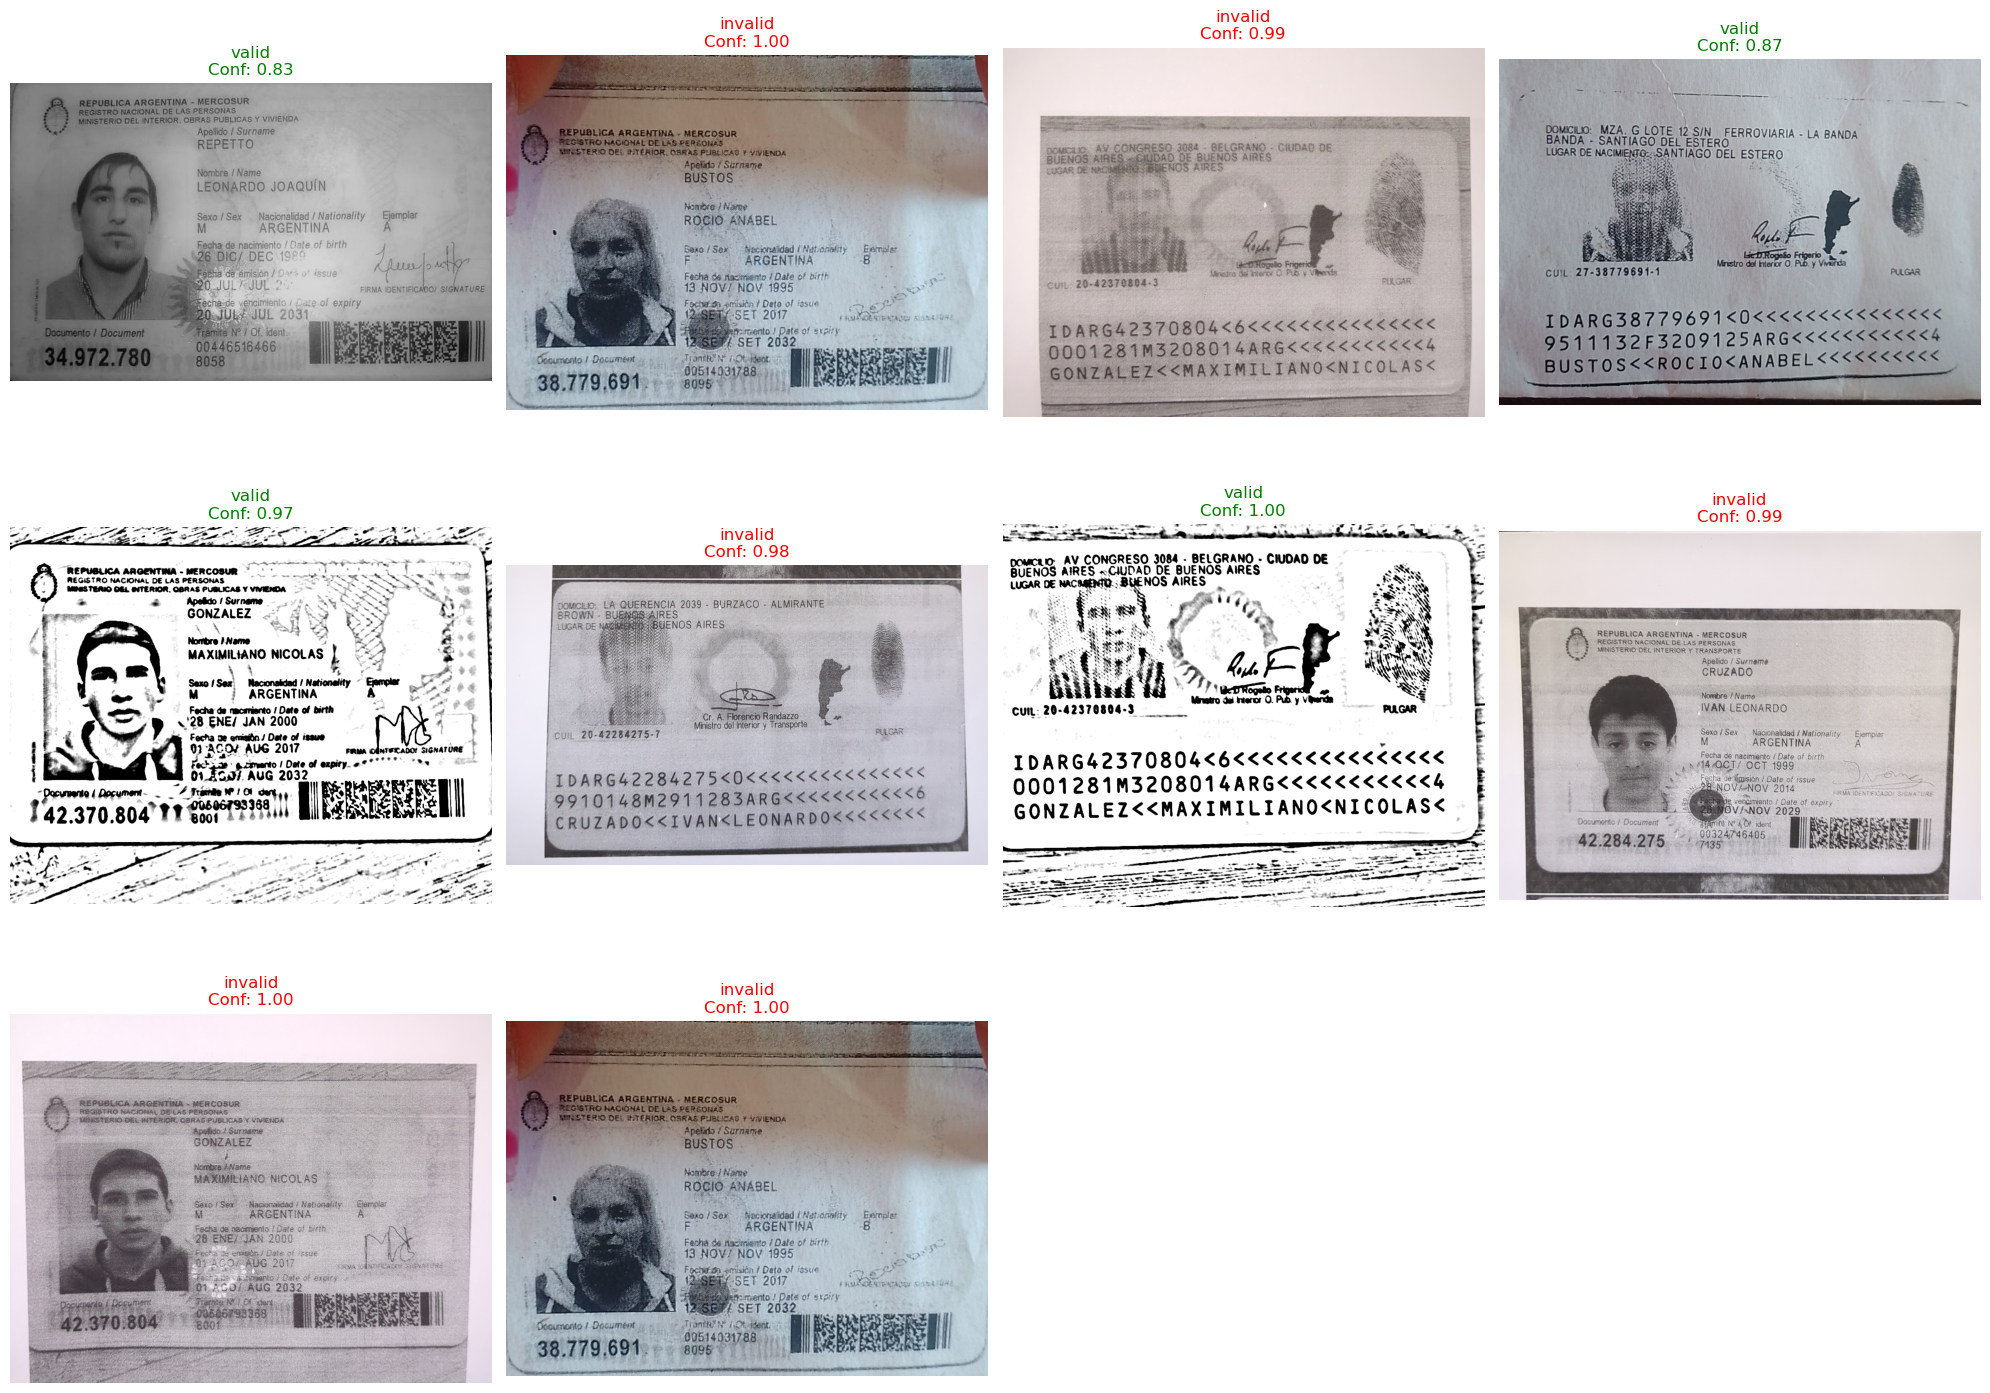

In [48]:
from ultralytics import YOLO
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def evaluate_and_plot_predictions(model_path, test_dir, num_images=100):
    """
    Evalúa imágenes y muestra cada una con su predicción
    """
    # Cargar modelo
    model = YOLO(model_path)
    
    # Obtener lista de imágenes
    images = []
    for ext in ['.jpg', '.jpeg', '.png']:
        images.extend(list(Path(test_dir).glob(f'*{ext}')))
        images.extend(list(Path(test_dir).glob(f'*{ext.upper()}')))
    
    # Limitar a num_images
    images = images[:num_images]
    
    print(f"Evaluando {len(images)} imágenes...")
    
    # Configurar el subplot grid
    n_cols = 4
    n_rows = (len(images) + n_cols - 1) // n_cols
    fig = plt.figure(figsize=(20, 5*n_rows))
    
    valid_count = 0
    for idx, img_path in enumerate(tqdm(images)):
        # Predecir
        results = model.predict(str(img_path), verbose=False)
        pred_class = results[0].names[results[0].probs.top1]
        confidence = float(results[0].probs.top1conf)
        
        if pred_class == 'valid':
            valid_count += 1
        
        # Cargar y mostrar imagen
        ax = fig.add_subplot(n_rows, n_cols, idx + 1)
        img = mpimg.imread(str(img_path))
        ax.imshow(img)
        ax.axis('off')
        
        # Color del título basado en la predicción
        color = 'green' if pred_class == 'valid' else 'red'
        ax.set_title(f'{pred_class}\nConf: {confidence:.2f}', color=color)
    
    plt.tight_layout()
    
    print(f"\nResultados:")
    print(f"Total imágenes evaluadas: {len(images)}")
    print(f"Clasificadas como 'valid': {valid_count}")
    print(f"Clasificadas como 'invalid': {len(images) - valid_count}")
    print(f"Porcentaje 'valid': {(valid_count/len(images))*100:.2f}%")
    
    plt.show()
    return valid_count

# Ejemplo de uso
if __name__ == "__main__":
    model_path = "runs/classify/train6/weights/best.pt"
    test_directory = "test"
    
    valid_count = evaluate_and_plot_predictions(model_path, test_directory, num_images=100)